In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib
from math import pow

In [4]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

In [5]:
path = Path("/data/Datasets/EIPH_WSI/HumanExpert/Predictions/")
gt_path = Path("/data/Datasets/EIPH_WSI/HumanExpert/GT/")

In [6]:
file_to_id = {}
id = 0

gt = []
for file in glob(str(gt_path/'*/*.bmp')):
    file = Path(file)

    label = int(file.parent.stem)
    gt.append(label)

    file_to_id[file.stem] = id
    id += 1

gt = np.array(gt)

In [7]:
fleiss_kappa_df = pd.DataFrame([[file, 0, 0, 0, 0, 0, 0] for file in file_to_id], columns = ['Name', 0, 1, 2, 3, 4, 'Pi'])
fleiss_kappa_df.head()

,Name,0,1,2,3,4,Pi
0,22_EIPH_575216 Turnbull blue_56688,0,0,0,0,0,0
1,26_EIPH_566482 L Berliner Blau_76337,0,0,0,0,0,0
2,26_EIPH_566482 L Berliner Blau_70527,0,0,0,0,0,0
3,01_EIPH_563479 Berliner Blau_887,0,0,0,0,0,0
4,02_EIPH_574162 berliner blau_10160,0,0,0,0,0,0


In [8]:
results_vo = {}
results_v1 = {}
results_ensemble = [[] for i in range(len(gt))]

for file in glob(str(path/'*')):
    file = Path(file)
    reviewer = file.name
    
    results_vo[reviewer] = np.zeros_like(gt) - 1
    results_v1[reviewer] = np.zeros_like(gt) - 1


    for cell_path in glob(str(file/'v0/*/*.bmp')):
        cell_path = Path(cell_path)

        if cell_path.stem in file_to_id:
            id = file_to_id[cell_path.stem]
            results_vo[file.stem][id] = int(cell_path.parent.stem)
            results_ensemble[id].append(int(cell_path.parent.stem))
            
            #if id < len(fleiss_kappa_df) and "DL_" not in reviewer:
            #    fleiss_kappa_df.loc[id, int(cell_path.parent.stem)] += 1
            
        
    for cell_path in glob(str(file/'v1/*/*.bmp')):
        cell_path = Path(cell_path)

        if cell_path.stem in file_to_id:
            id = file_to_id[cell_path.stem]
            results_v1[file.stem][id] = int(cell_path.parent.stem)
            results_ensemble[id].append(int(cell_path.parent.stem))
            
            if id < len(fleiss_kappa_df) and "DL_" not in reviewer:
                fleiss_kappa_df.loc[id, int(cell_path.parent.stem)] += 1

In [9]:
fleiss_kappa_df.head()

,Name,0,1,2,3,4,Pi
0,22_EIPH_575216 Turnbull blue_56688,0,0,7,2,0,0
1,26_EIPH_566482 L Berliner Blau_76337,0,0,8,0,0,0
2,26_EIPH_566482 L Berliner Blau_70527,0,0,8,0,0,0
3,01_EIPH_563479 Berliner Blau_887,0,0,0,9,0,0
4,02_EIPH_574162 berliner blau_10160,0,0,8,0,0,0


In [10]:
#https://en.wikipedia.org/wiki/Fleiss%27_kappa
totoal_votes = 0
for i, trial in fleiss_kappa_df.iterrows():
    num_votes = sum([trial[t] for t in range(5)])
    totoal_votes += num_votes
    if num_votes > 0: 
        fleiss_kappa_df.loc[i, 'Pi'] = (1 / (num_votes*(num_votes-1))) * (sum([pow(trial[t],2) for t in range(5)]) - num_votes)

In [11]:
fleiss_kappa_df.head()

,Name,0,1,2,3,4,Pi
0,22_EIPH_575216 Turnbull blue_56688,0,0,7,2,0,0.611111
1,26_EIPH_566482 L Berliner Blau_76337,0,0,8,0,0,1.000000
2,26_EIPH_566482 L Berliner Blau_70527,0,0,8,0,0,1.000000
3,01_EIPH_563479 Berliner Blau_887,0,0,0,9,0,1.000000
4,02_EIPH_574162 berliner blau_10160,0,0,8,0,0,1.000000


In [12]:
pj = [sum(fleiss_kappa_df[i].tolist()) / totoal_votes for i in range(5)] 
pj

[0.25662024030127323,
 0.2604459322135214,
 0.21214657182138802,
 0.14681092713252436,
 0.12397632853129296]

In [13]:
P = np.mean(fleiss_kappa_df['Pi'].tolist())
P

0.7485253401920069

In [14]:
Pe = sum([pow(p,2) for p in pj])
Pe

0.2156157776360312

In [15]:
K = (P - Pe) / (1 - Pe)
K

0.6793986255229593

In [16]:
fleiss_kappa_df.head() #.sort_values(by=['Pi'])

,Name,0,1,2,3,4,Pi
0,22_EIPH_575216 Turnbull blue_56688,0,0,7,2,0,0.611111
1,26_EIPH_566482 L Berliner Blau_76337,0,0,8,0,0,1.000000
2,26_EIPH_566482 L Berliner Blau_70527,0,0,8,0,0,1.000000
3,01_EIPH_563479 Berliner Blau_887,0,0,0,9,0,1.000000
4,02_EIPH_574162 berliner blau_10160,0,0,8,0,0,1.000000


In [8]:
results_ensemble = [np.bincount(i) for i in results_ensemble]
for i in range(len(results_ensemble)):
    if len(results_ensemble[i]) == 0:
        results_ensemble[i] = [0]
    results_ensemble[i]  = np.argmax(results_ensemble[i])

In [9]:
accuracy_score(gt, results_ensemble)

0.8275

### ACC

In [10]:
regression_gt = np.mean(gt)
regression_gt

1.4775

In [11]:
matrix_list = []

for reviewer in results_vo:
    if "DL_" not in reviewer:
        prediction_vo = results_vo[reviewer]
        prediction_v1 = results_v1[reviewer]

        if len(prediction_vo[prediction_vo >= 0]) > 0:
            matrix_list.append(confusion_matrix(gt[prediction_vo >= 0], prediction_vo[prediction_vo >= 0]))
        if len(prediction_vo[prediction_v1 >= 0]) > 0:
            matrix_list.append(confusion_matrix(gt[prediction_v1 >= 0], prediction_v1[prediction_v1 >= 0]))

In [12]:
np_matrix = np.array(matrix_list)

temp = np_matrix[0]
for i in range(1, len(np_matrix)):
    temp += np_matrix[i]

In [13]:
temp

array([[8024, 1361,   12,    5,    0],
       [ 470, 7159, 2167,  111,    3],
       [   2,  320, 4603, 2208,   98],
       [   0,    0,  253, 2464, 1587],
       [   0,    0,    1,  193, 2595]])

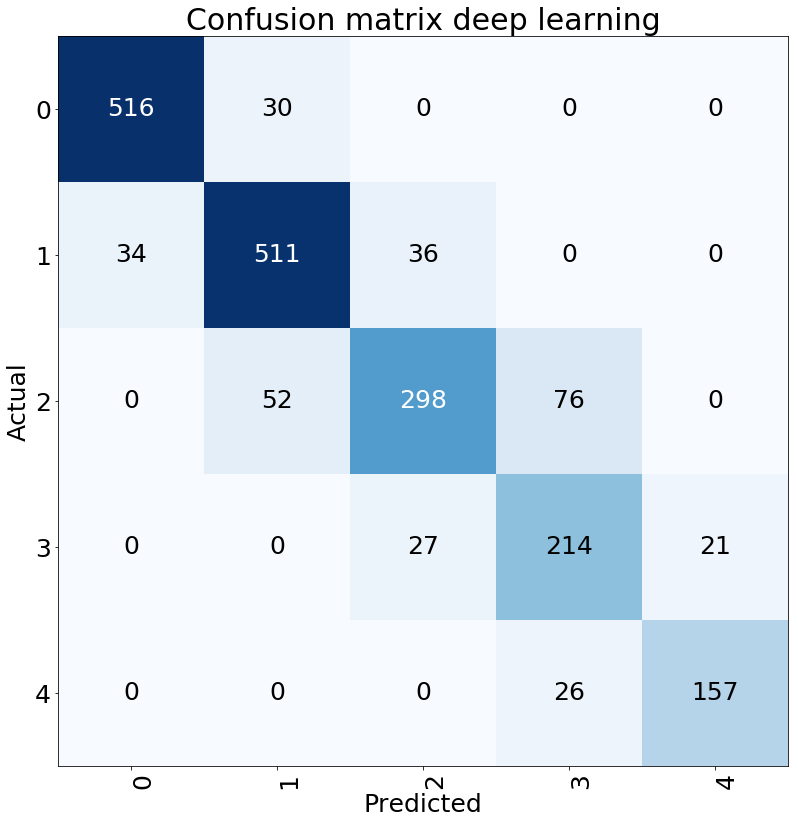

In [30]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25

prediction_vo = results_vo["DL_Class"]

cm = confusion_matrix(gt[prediction_vo >= 0], prediction_vo[prediction_vo >= 0])
cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)


ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4],
           title="Confusion matrix deep learning",
           ylabel='Actual',
           xlabel='Predicted')

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'#'.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

plt.savefig("ConfusionMatrix.pdf", transparent=True)

In [207]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

class_accuracys = [[], [], [], [], []] 

for reviewer in results_vo:
    
    if "DL" in reviewer:
        continue
    
    print(reviewer)
    
    #print(classification_report(gt, results_v1[reviewer]))

    for i in range(5):
        temp_prediction_vo = np.copy(results_v1[reviewer])
        temp_gt = np.copy(gt)


        index_vo_k_0 = temp_prediction_vo == i
        index_vo_k_1 = temp_prediction_vo != i

        index_gt_k_0 = temp_gt == i
        index_gt_k_1 = temp_gt != i 

        temp_prediction_vo[index_vo_k_0] = 1
        temp_prediction_vo[index_vo_k_1] = 0

        temp_gt[index_gt_k_0] = 1
        temp_gt[index_gt_k_1] = 0

        or_list = np.logical_or(temp_gt, temp_prediction_vo)

        
        class_accuracys[i].append(f1_score(temp_prediction_vo[or_list], temp_gt[or_list]))
        print(f1_score(temp_prediction_vo[or_list], temp_gt[or_list])) #, average='weighted'
    

B_2
0.9252925292529253
0.8188539741219965
0.6811779769526249
0.5659050966608085
0.7767857142857142
P_1
0.8915662650602411
0.6414342629482072
0.5807770961145194
0.34237995824634654
0.6841121495327103
P_3
0.9155555555555556
0.744138634046891
0.6181384248210025
0.49391304347826087
0.7357293868921776
E_3
0.9287020109689214
0.8311688311688311
0.6887755102040816
0.6702317290552584
0.8542713567839196
B_1
0.9036027263875365
0.767097966728281
0.7228144989339019
0.3844282238442822
0.6853932584269664
E_2
0.6634499396863691
0.5916398713826366
0.3896940418679549
0.1702127659574468
0.09958506224066391
B_3
0.8454258675078865
0.6715462031107046
0.6365591397849463
0.5169811320754717
0.7336065573770492
P_2
0.9155470249520153
0.7512007684918347
0.6157407407407408
0.541095890410959
0.09374999999999999
E_1
0.8682170542635659
0.7703703703703703
0.5255255255255254
0.6151761517615176
0.8328445747800587


In [208]:
np.array(class_accuracys)

array([[0.92529253, 0.89156627, 0.91555556, 0.92870201, 0.90360273,
        0.66344994, 0.84542587, 0.91554702, 0.86821705],
       [0.81885397, 0.64143426, 0.74413863, 0.83116883, 0.76709797,
        0.59163987, 0.6715462 , 0.75120077, 0.77037037],
       [0.68117798, 0.5807771 , 0.61813842, 0.68877551, 0.7228145 ,
        0.38969404, 0.63655914, 0.61574074, 0.52552553],
       [0.5659051 , 0.34237996, 0.49391304, 0.67023173, 0.38442822,
        0.17021277, 0.51698113, 0.54109589, 0.61517615],
       [0.77678571, 0.68411215, 0.73572939, 0.85427136, 0.68539326,
        0.09958506, 0.73360656, 0.09375   , 0.83284457]])

In [209]:
np.mean(np.array(class_accuracys), axis=1)

array([0.87303989, 0.73193899, 0.60657811, 0.47781378, 0.61067534])

In [210]:
np.std(np.array(class_accuracys), axis=1)

array([0.07848149, 0.07612562, 0.09499873, 0.14572906, 0.28016706])

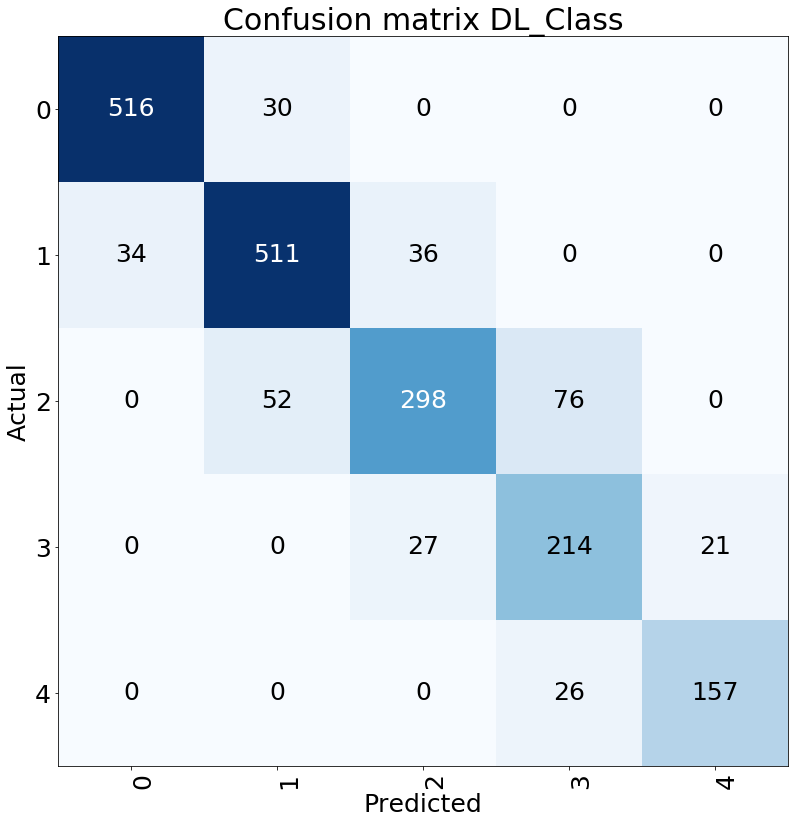

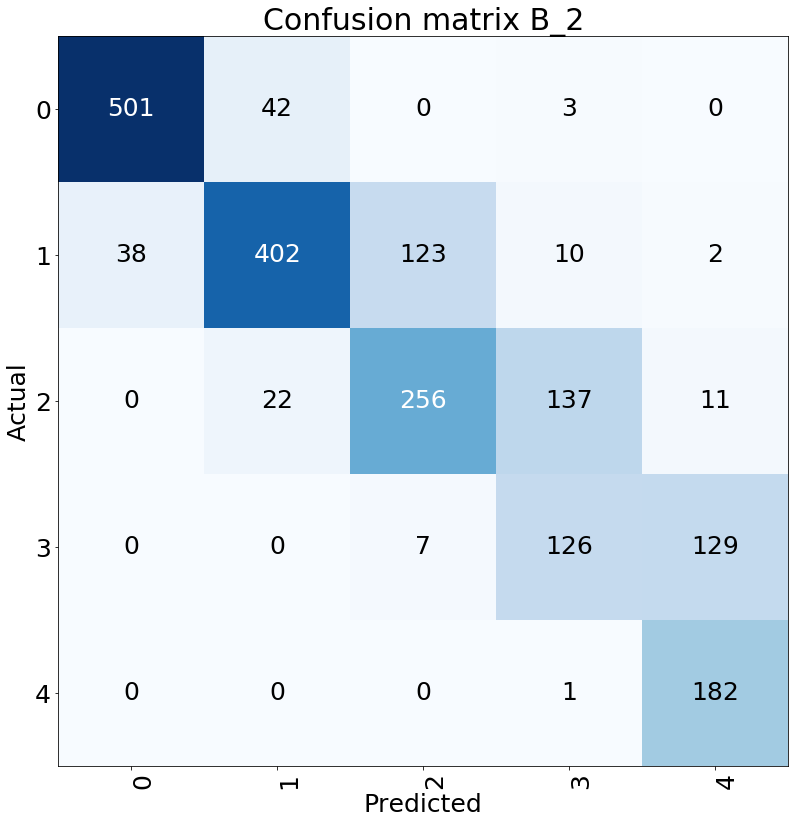

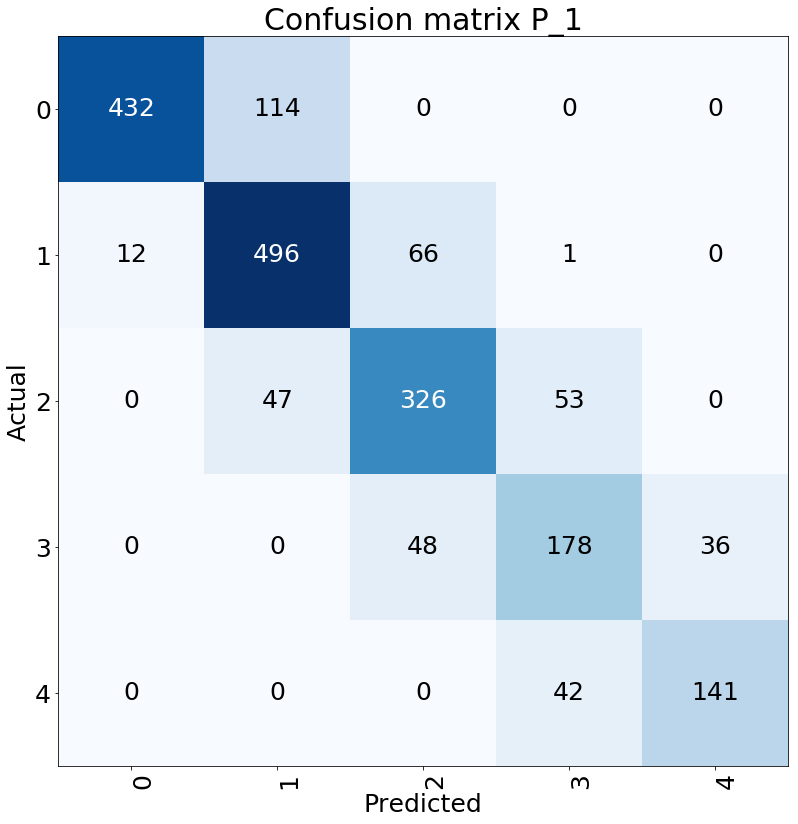

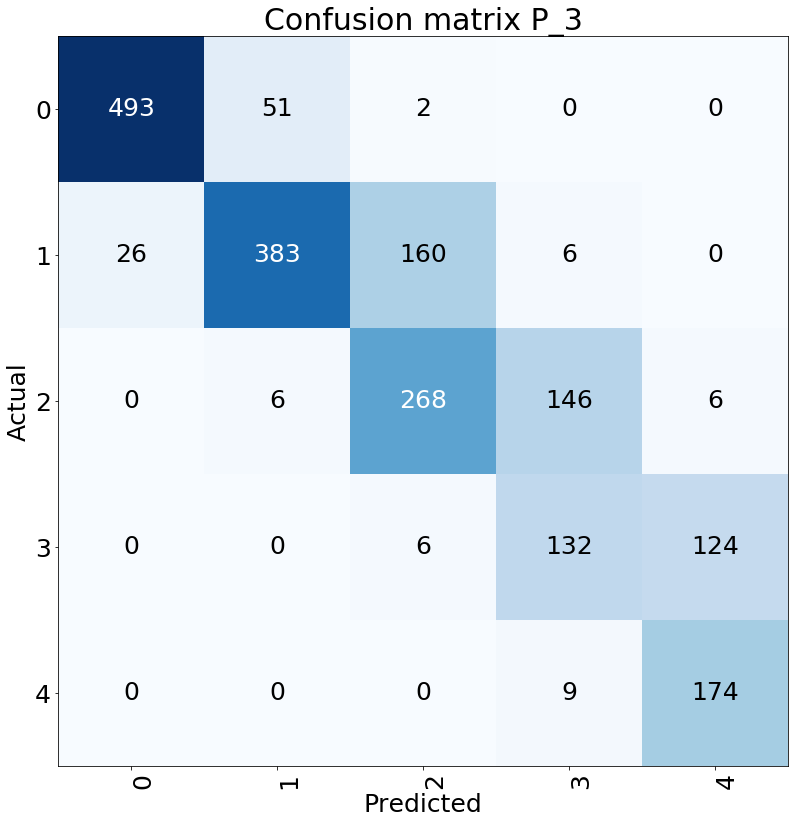

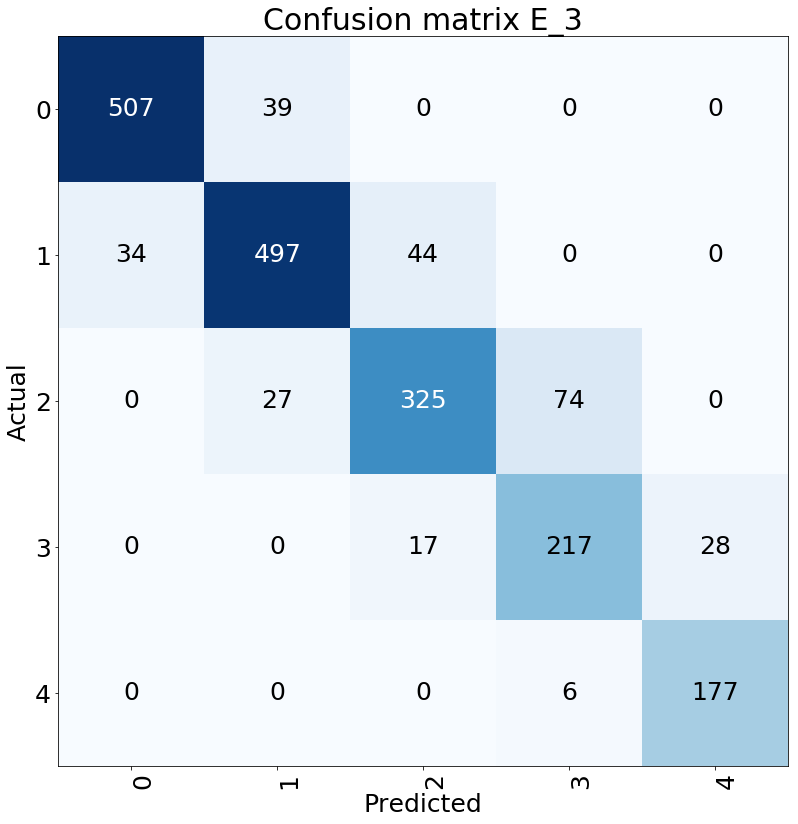

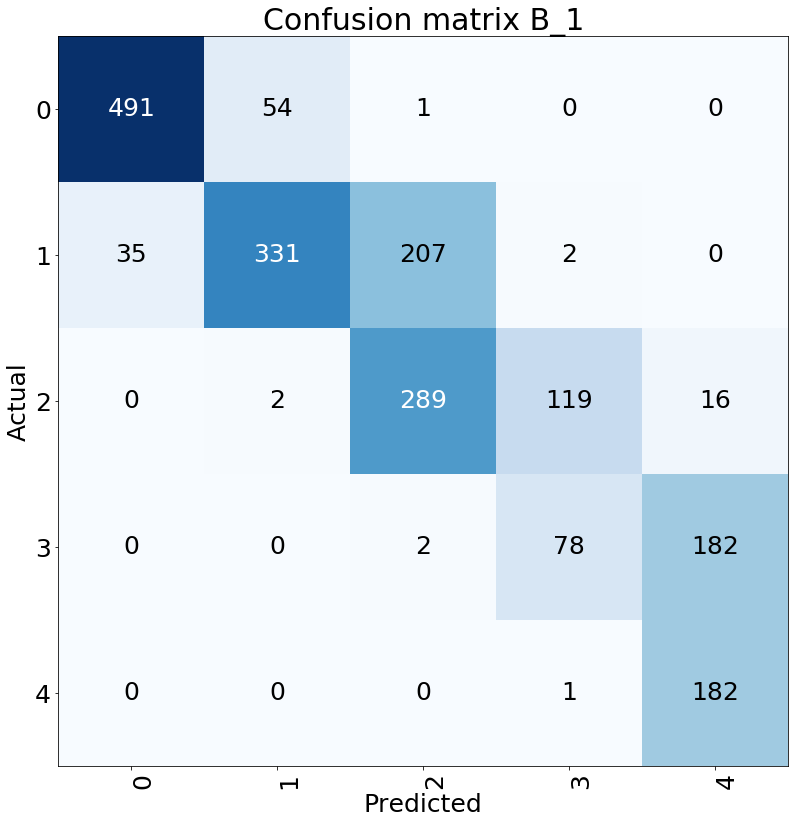

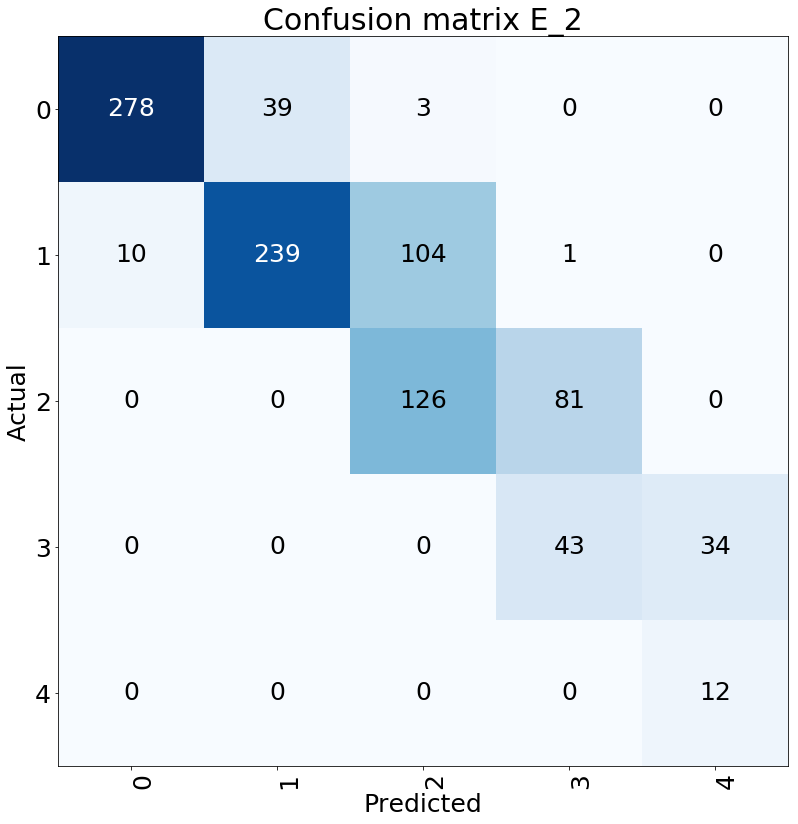

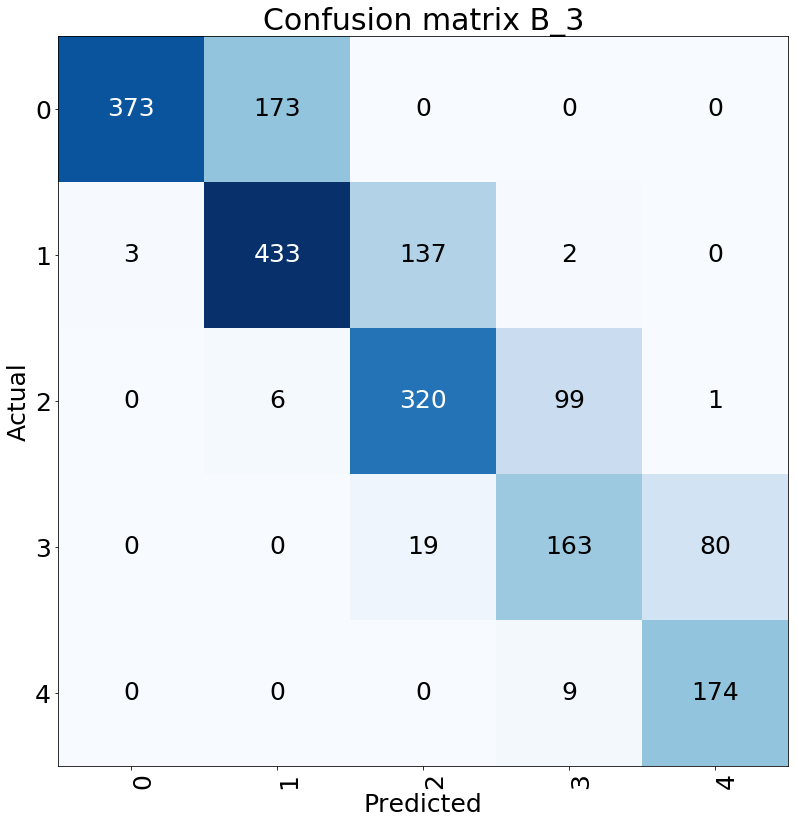

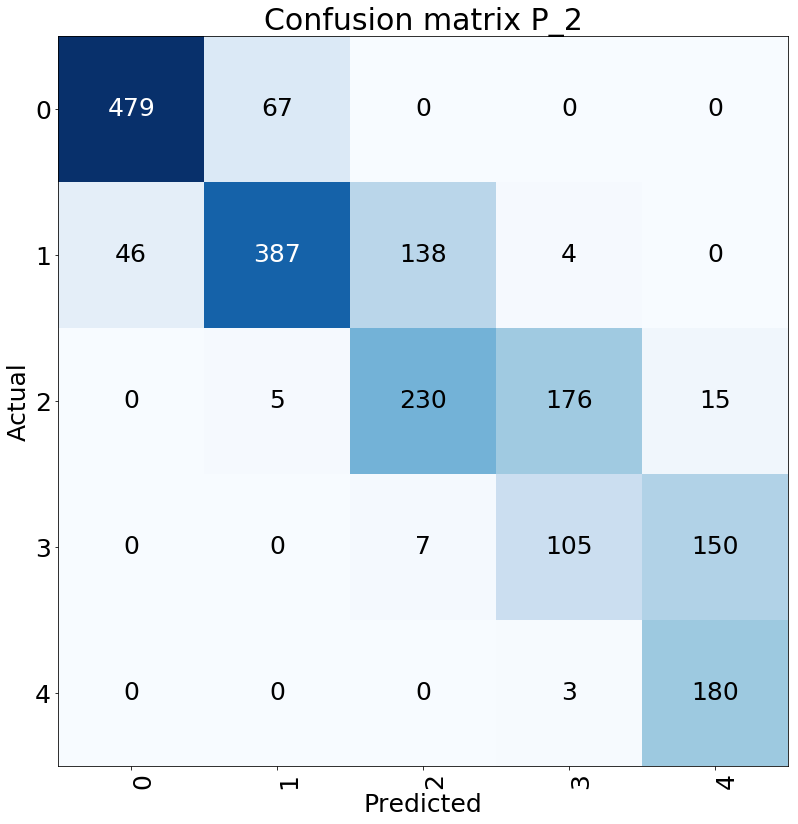

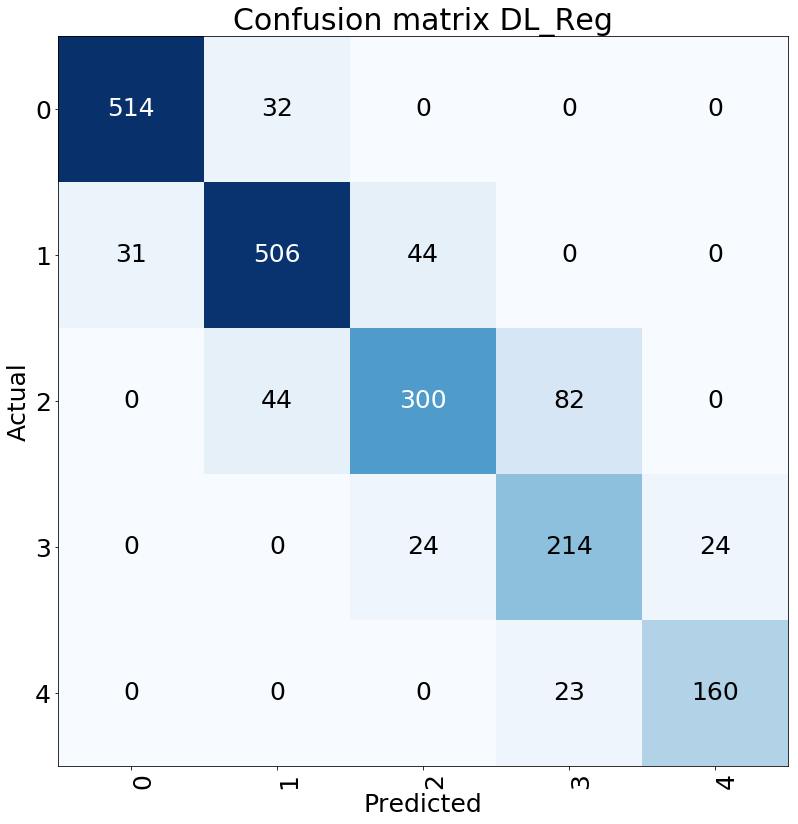

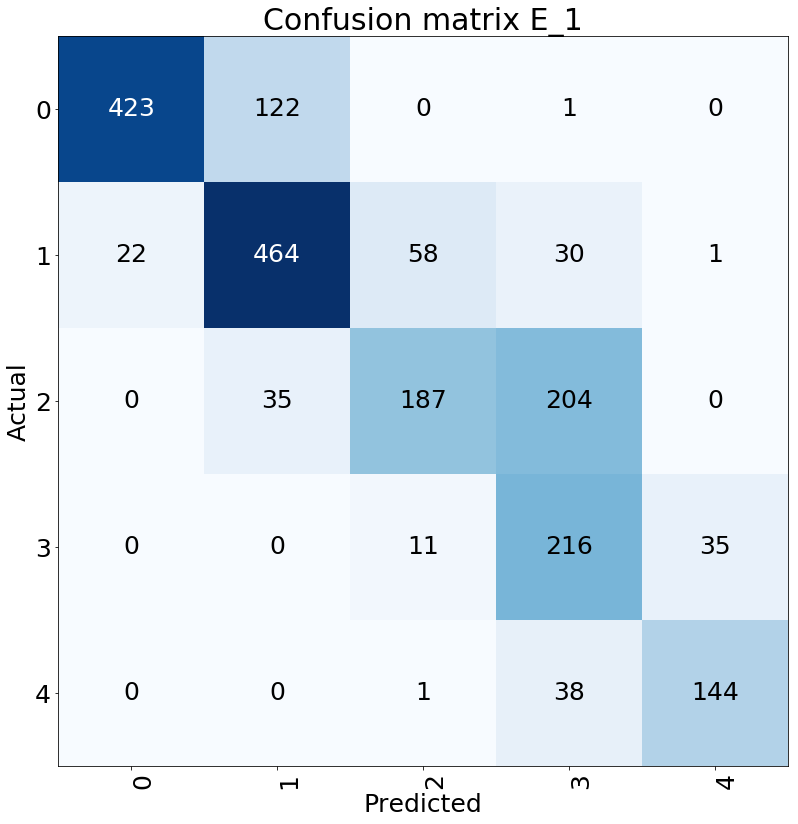

In [148]:
for reviewer in results_vo:

    prediction_vo = results_vo[reviewer]

    cm = confusion_matrix(gt[prediction_vo >= 0], prediction_vo[prediction_vo >= 0])
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)


    ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4],
               title="Confusion matrix {}".format(reviewer),
               ylabel='Actual (Ground Truth)',
               xlabel='Predicted')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'#'.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.savefig("ConfusionMatrix_{}.pdf".format(reviewer), transparent=True)

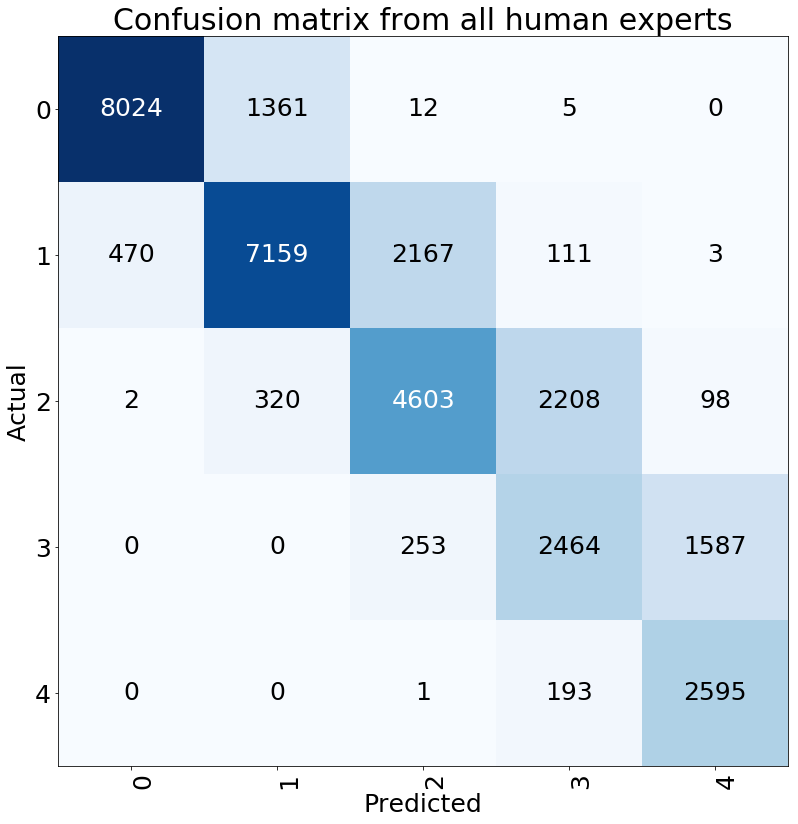

In [29]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25
#plt.figure(figsize=(128,128))

cm = temp
cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4],
           title="Confusion matrix from all human experts",
           ylabel='Actual (Ground Truth)',
           xlabel='Determined') #Determined

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'#'.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

plt.savefig("ConfusionMatrixHumanExpert.pdf", transparent=True)

In [55]:
results_vo = {'B_1': results_vo['B_1'], 'B_2': results_vo['B_2'], 'B_3': results_vo['B_3'],
'P_1': results_vo['P_1'], 'P_2': results_vo['P_2'], 'P_3': results_vo['P_3'],
'E_1': results_vo['E_1'], 'E_2': results_vo['E_2'], 'E_3': results_vo['E_3'],
'DL_Class': results_vo['DL_Class'], 'DL_Reg': results_vo['DL_Reg']}
 
results_v1 = {'B_1': results_v1['B_1'], 'B_2': results_v1['B_2'], 'B_3': results_v1['B_3'],
'P_1': results_v1['P_1'], 'P_2': results_v1['P_2'], 'P_3': results_v1['P_3'],
'E_1': results_v1['E_1'], 'E_2': results_v1['E_2'], 'E_3': results_v1['E_3'],
'DL_Class': results_v1['DL_Class'], 'DL_Reg': results_v1['DL_Reg']}

In [78]:
data_acc = []
data_regression = []

for reviewer in results_vo:
    prediction_vo = results_vo[reviewer]
    prediction_v1 = results_v1[reviewer]
    
    score_v0 = regression_gt - np.mean(prediction_vo[prediction_vo >= 0])
    score_v1 = regression_gt - np.mean(prediction_v1[prediction_vo >= 0])
    
    
    
    data_acc.append([reviewer, accuracy_score(gt[prediction_vo >= 0], prediction_vo[prediction_vo >= 0]), 
                     accuracy_score(gt[prediction_v1 >= 0], prediction_v1[prediction_v1 >= 0]), 
                     cohen_kappa_score(prediction_vo[prediction_vo >= 0], prediction_v1[prediction_vo >= 0]),
                     accuracy_score(prediction_vo[prediction_vo >= 0], prediction_v1[prediction_vo >= 0]),
                    
                    ])
    data_regression.append([reviewer, score_v0, score_v1, regression_gt, np.mean(prediction_vo[prediction_vo >= 0])])
    

In [79]:
df_acc = pd.DataFrame(data_acc, columns = ['Name', 'Con-V0', 'Con-V1', 'Kappa', 'Con-IR'])#.sort_values(by=['Name'])
df_reg = pd.DataFrame(data_regression, columns = ['Name', 'Con-V0', 'Con-V1', 'regression_gt', 'score_v0']) 
df_acc

,Name,Con-V0,Con-V1,Kappa,Con-IR
0,B_1,0.688253,0.742972,0.782411,0.829819
1,B_2,0.736446,0.782521,0.774195,0.822289
2,B_3,0.734438,0.693273,0.760644,0.812249
3,P_1,0.789659,0.660141,0.601803,0.686245
4,P_2,0.693273,0.729715,0.638787,0.707329
5,P_3,0.727912,0.730422,0.771103,0.819277
6,E_1,0.719880,0.732932,0.741461,0.802209
7,E_2,0.719588,0.716000,0.842439,0.881443
8,E_3,0.864960,0.811245,0.785795,0.833835
9,DL_Class,0.848849,0.848849,1.000000,1.000000


In [80]:
df_reg

,Name,Con-V0,Con-V1,regression_gt,score_v0
0,B_1,-0.282038,-0.215271,1.4775,1.759538
1,B_2,-0.211757,-0.122400,1.4775,1.689257
2,B_3,-0.230833,-0.299608,1.4775,1.708333
3,P_1,-0.062159,-0.320693,1.4775,1.539659
4,P_2,-0.255934,0.280211,1.4775,1.733434
5,P_3,-0.232841,-0.188665,1.4775,1.710341
6,E_1,-0.190171,-0.113865,1.4775,1.667671
7,E_2,0.134201,0.143479,1.4775,1.343299
8,E_3,-0.051616,-0.050110,1.4775,1.529116
9,DL_Class,-0.011489,-0.011489,1.4775,1.488989


In [51]:
symbols = {"B_1": "o", 
           "B_2": "o",
           "B_3": "o",
           "P_1": "D",
           "P_2": "D",           
           "P_3": "D", 
           "E_1": '*',
           "E_2": "*",  
           "E_3": '*',
           
           "DL_Reg": "<",
           "DL_Class": ">",
           
        }

color = {"B_1": "c",  
         "B_2": "r",
         "B_3": "m",
         "P_1": "c",
         "P_2": "r",         
         "P_3": "m",
         "E_1": "c",
         "E_2": 'r', 
        "E_3": 'm',
         
        "DL_Reg": "b",
        "DL_Class": "b",}


offset = {"B_1": 0.15, 
           "B_2": 0.2,
           "B_3": 0.25,
           "P_1": -0.15,
           "P_2": -0.2,           
           "P_3": -0.25, 
           "E_1": -0.05,
           "E_2": 0,  
           "E_3": 0.05,
           
           "DL_Reg": 0,
           "DL_Class": 0,
           
        }


In [20]:
temp_data = pd.melt(df_acc[['Con-V0', 'Con-V1']])
temp_data = temp_data.astype({"value": float, "variable": str})

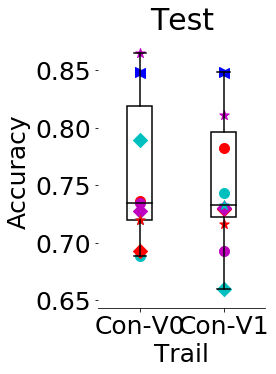

In [59]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25

f, ax = plt.subplots(figsize=(3, 5))

temp_data = pd.melt(df_acc[['Con-V0', 'Con-V1']]) #
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3, color='white') 
#ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3) #, hue="variable"
#ax.set(ylim=(0.6, 1))

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')


for index, row in enumerate(df_acc.values.tolist()):
    name = row[0]
    acc_0 = row[1]
    acc_1 = row[2]
    
    plt.scatter(x=0, y=acc_0, marker=symbols[name], label=name, s=100, c=color[name])
    plt.scatter(x=1, y=acc_1, marker=symbols[name], s=100, c=color[name])


#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
#ax.legend(bbox_to_anchor=(1.45, 0.8), prop={'size': 25}, frameon=False)

ax.set(ylabel="Accuracy", xlabel="Trail", title="Test")
sns.despine(left=True)

plt.savefig("CellAccuracy.pdf", transparent=True)

In [22]:
df_acc[['Kappa']]

,Kappa
0,1.000000
1,0.774195
2,0.601803
3,0.771103
4,0.785795
5,0.782411
6,0.842439
7,0.760644
8,0.638787
9,1.000000


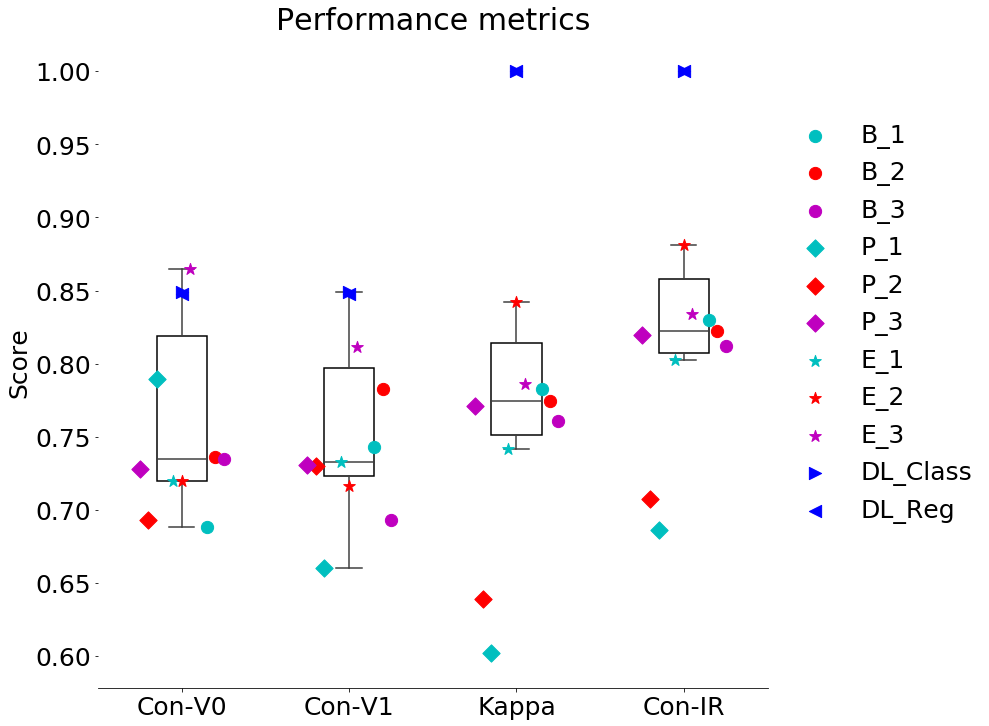

In [62]:
f, ax = plt.subplots(figsize=(12, 12))

temp_data = pd.melt(df_acc[['Con-V0', 'Con-V1', 'Kappa', 'Con-IR']]) #'Con-V0', 'Con-V1', 'Kappa', 'Con-IR'
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3,  showfliers=False) #
#ax.set(ylim=(0.55, 1))


for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    #for j in range(6*i,6*(i+1)):
    #     ax.lines[j].set_color('black')



for index, row in enumerate(df_acc.values.tolist()):
    name = row[0]
    acc_0 = row[1]
    acc_1 = row[2]
    kappa = row[3]
    acc = row[4]

    
    plt.scatter(x=0 + offset[name], y=acc_0, marker=symbols[name], label=name, s=150, c=color[name], zorder=100)
    plt.scatter(x=1 + offset[name], y=acc_1, marker=symbols[name], s=150, c=color[name], zorder=100)
    
    plt.scatter(x=2 + offset[name], y=kappa, marker=symbols[name], s=150, c=color[name], zorder=100)
    plt.scatter(x=3 + offset[name], y=acc, marker=symbols[name], s=150, c=color[name], zorder=100)


#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
ax.legend(bbox_to_anchor=(1., 0.9), prop={'size': 25}, frameon=False)

ax.set(ylabel="Score", xlabel="", title="Performance metrics")
sns.despine(left=True)

plt.savefig("KappaScore.pdf", transparent=True)

In [24]:
regression_gt

1.4775

In [63]:
df_reg

,Name,Con-V0,Con-V1
0,B_1,0.282038,0.215271
1,B_2,0.211757,0.122400
2,B_3,0.230833,0.299608
3,P_1,0.062159,0.320693
4,P_2,0.255934,-0.280211
5,P_3,0.232841,0.188665
6,E_1,0.190171,0.113865
7,E_2,-0.134201,-0.143479
8,E_3,0.051616,0.050110
9,DL_Class,0.011489,0.011489


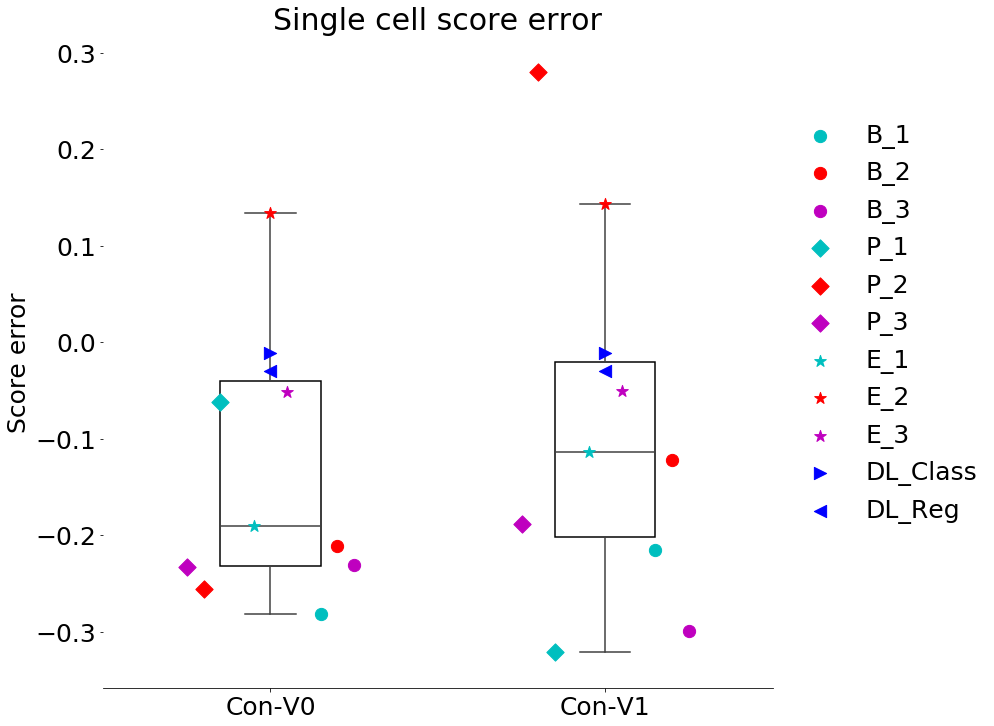

In [82]:
f, ax = plt.subplots(figsize=(12, 12))

temp_data = pd.melt(df_reg[['Con-V0', 'Con-V1']])
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3,  showfliers=False) #
#ax.set(ylim=(0.55, 1))


for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    #for j in range(6*i,6*(i+1)):
    #     ax.lines[j].set_color('black')



for index, row in enumerate(df_reg.values.tolist()):
    name = row[0]
    acc_0 = row[1]
    acc_1 = row[2]

    
    plt.scatter(x=0 + offset[name], y=acc_0, marker=symbols[name], label=name, s=150, c=color[name], zorder=100)
    plt.scatter(x=1 + offset[name], y=acc_1, marker=symbols[name], s=150, c=color[name], zorder=100)

#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
ax.legend(bbox_to_anchor=(1., 0.9), prop={'size': 25}, frameon=False)

ax.set(ylabel="Score error", xlabel="", title="Single cell score error")
sns.despine(left=True)

plt.savefig("RegressionError.pdf", transparent=True)

In [269]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
    
    plt.setp([ax.get_xticklines() + ax.get_yticklines() + ax.get_xgridlines() + ax.get_ygridlines()],antialiased=False)
    mpl.rcParams['text.antialiased']=False
 
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

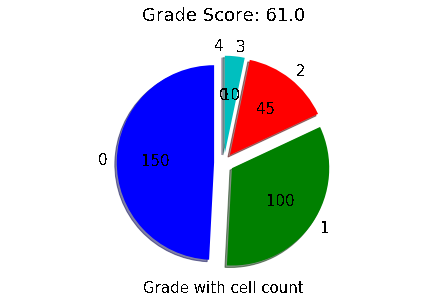

In [273]:
plt.rcParams["font.size"] = 15

# Pie chart
labels = ['0', '1', '2', '3', '4']
sizes = [150, 100, 45, 10, 0]

explode = (0.1, 0.1, 0.1, 0.1, 0.1)  


fig1, ax1 = plt.subplots()


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

ax1.set_title('Grade Score: {:2}'.format(np.mean(sizes)), y=1.08)
ax1.set_xlabel('Grade with cell count')

ax1.pie(sizes, explode=explode, labels=labels, colors = ['b', 'g', 'r', 'c', 'm'],
        shadow=True, startangle=90, autopct=make_autopct(sizes))
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 


plt.tight_layout(pad=0)
plt.show()

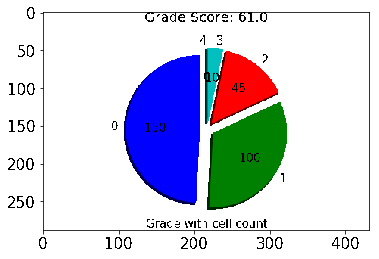

In [274]:
plt.imshow(fig2data(fig1)); plt.show()

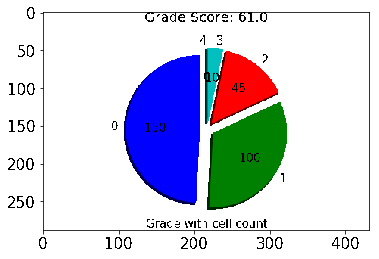

In [275]:
import matplotlib as mpl

plt.setp([ax.get_xticklines() + ax.get_yticklines() + ax.get_xgridlines() + ax.get_ygridlines()],antialiased=False)
mpl.rcParams['text.antialiased']=False

data = np.fromstring(fig1.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig1.canvas.get_width_height()[::-1] + (3,))

plt.imshow(data); plt.show()